In [256]:
from analysis.analysis import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [375]:
def heatmap(ax, F, bounds, xlabel=False, ylabel=False, cbar=False, cbar_label=False):
    xmin, xmax, vmin, vmax, nbins = bounds
    ax.set_xlabel(r"$x$ ($\mu$m)") if xlabel else ...
    ax.set_ylabel(r"$v$ ($\mu$m/hr)") if ylabel else ...
    _kwargs = {
        "extent": [xmin, xmax, vmin, vmax],
        "origin": "lower",
        "cmap": "jet",
        "interpolation": "bilinear",
    }
    im = ax.imshow(F, **_kwargs)
    if cbar:
        cbar = plt.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
    cbar.set_label(r"$F$ ($\mu$m/hr$^2$)") if cbar_label else ...
    ax.set_aspect("auto")


def streamplot(
    ax, F, bounds, title="", n_skip=1, zero_line=False, heatmap=False, **kwargs
):
    xmin, xmax, vmin, vmax, nbins = bounds
    ax.set_xlabel(r"$x$ ($\mu$m)")
    ax.set_ylabel(r"$v$ ($\mu$m/hr)")

    if heatmap:
        _kwargs = {
            "extent": [xmin, xmax, vmin, vmax],
            "origin": "lower",
            "cmap": "jet",
            "interpolation": "bilinear",
        }
        im = ax.imshow(F, **_kwargs)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
        ax.set_aspect("auto")

    X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
    init_pts = init_pts[::n_skip]
    stream_kwargs = kwargs | {"start_points": init_pts}
    ax.streamplot(X, Y, Y, F, **stream_kwargs)
    ax.set_title(title)
    if zero_line:
        ax.hlines(0, *ax.get_xlim(), lw=1, color="black", zorder=-1)


def bistable_streamplot(
    ax,
    F,
    bounds,
    labels,
    end_pts,
    title="",
    n_skip=1,
    zero_line=False,
    heatmap=False,
    **kwargs
):
    xmin, xmax, vmin, vmax, nbins = bounds
    ax.set_xlabel(r"$x$ ($\mu$m)")
    ax.set_ylabel(r"$v$ ($\mu$m/hr)")

    if heatmap:
        _kwargs = {
            "extent": [xmin, xmax, vmin, vmax],
            "origin": "lower",
            "cmap": "jet",
            "interpolation": "bilinear",
        }
        im = ax.imshow(F, **_kwargs)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
        ax.set_aspect("auto")

    X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
    init_pts_sub = init_pts[::n_skip]
    labels_sub = labels[::n_skip]
    for color in set(labels_sub):
        inits_ = init_pts_sub[np.where(np.array(labels_sub) == color)[0]]
        stream_kwargs = kwargs | {"color": color, "start_points": inits_}
        ax.streamplot(X, Y, Y, F, **stream_kwargs)
        ax.scatter(
            end_pts[:, 0], end_pts[:, 1], s=30, marker="*", color="black", zorder=10
        )
        img = lattice_to_image(init_pts, labels, bounds)
        septx = get_separatrices(
            img, levels=[0.5], origin="lower", extent=[xmin, xmax, vmin, vmax]
        )
        ax.plot(septx[:, 0], septx[:, 1], lw=2, color="black")

    ax.set_title(title)
    if zero_line:
        ax.hlines(0, *ax.get_xlim(), lw=1, color="black", zorder=-1)


def dynamicsplot(ax, F, bounds):
    X, Y, init_pts = full_lattice(F, *bounds)

    # raw
    v, f = evaluate_F_v_x0(Y, F, bounds[-1])
    lim = np.fabs([v.min(), v.max()]).min()
    v_interp = np.linspace(-lim, lim, 30)
    f_interp = np.interp(v_interp, v, f)

    ax.plot(v_interp, f_interp, "-o", lw=2, color="black")
    ax.grid(which="major")
    ax.set_xlabel(r"$v$ ($\mu$m/hr)")
    ax.set_ylabel(r"$F(x\rightarrow 0)$ ($\mu$m/hr$^2$)")

In [258]:
def process_gid(gid, bistable=False, min_pts=10):
    nbins = 32
    xva_df = get_xva_df(
        apply_time_filter(
            read_fulltake(
                f"../_server/sim_data/defaults/parquets/fulltake_gid{gid}.parquet",
                scale_position=True,
            ),
            dt=3,
            base_rate=3,
        ),
        nbins,
        yfile=f"../_server/sim_data/defaults/configs/grid_id{gid}/simbox.yaml",
    )

    bounds, F, sigma = compute_F_sigma(xva_df, nbins=nbins, min_pts=min_pts)
    xmin, xmax = bounds["x"]
    vmin, vmax = bounds["v"]
    bounds_tup = (xmin, xmax, vmin, vmax, nbins)
    if bistable:
        X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
        labels, end_pts = get_labels(init_pts, X, Y, F)
        return F, bounds_tup, labels, np.array(end_pts)
    return F, bounds_tup

In [259]:
kwargs = {
    "density": 10,
    "linewidth": 0.5,
    "arrowsize": 0.75,
    "integration_direction": "forward",
    "broken_streamlines": True,
    "color": "cornflowerblue",
}

---

### Fig 1

In [ ]:
lc_F, lc_bounds = process_gid(10)
st_F, st_bounds = process_gid(26)

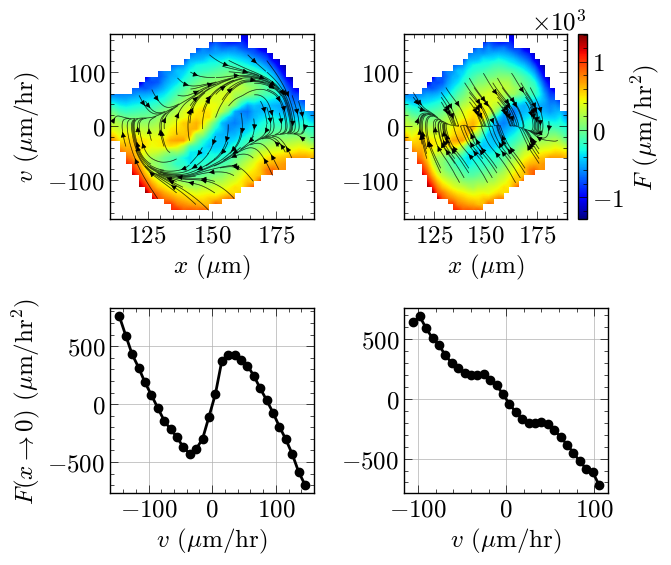

In [391]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3 * nrows))

heatmap(axs[0, 0], lc_F, lc_bounds, xlabel=True, ylabel=True)
heatmap(axs[0, 1], lc_F, lc_bounds, xlabel=True, cbar=True, cbar_label=True)

streamplot(
    axs[0, 0], lc_F, lc_bounds, n_skip=6, zero_line=True, **kwargs | {"color": "black"}
)
streamplot(
    axs[0, 1], st_F, st_bounds, n_skip=6, zero_line=True, **kwargs | {"color": "black"}
)
axs[0, 1].set_ylabel("")

dynamicsplot(axs[1, 0], lc_F, lc_bounds)
dynamicsplot(axs[1, 1], st_F, st_bounds)
axs[1, 1].set_ylabel("")
plt.tight_layout()
fig.savefig("paper_plots/lc_stationary_defaults.pdf")

### Fig. 2

In [408]:
F1, b1, lbs, end = process_gid(2, True)
F2, b2 = process_gid(10)
F3, b3 = process_gid(122)

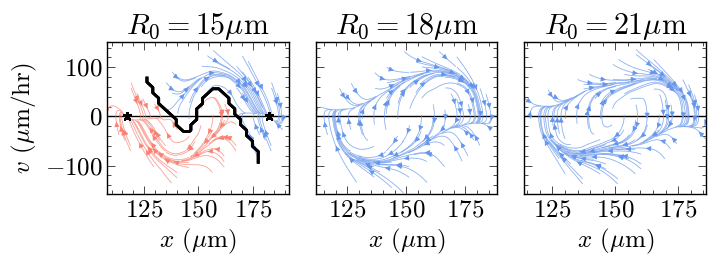

In [411]:
nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3 * nrows), sharey=True)

bistable_streamplot(
    axs[0],
    F1,
    b1,
    lbs,
    end,
    title=r"$R_0=15\mu\mathrm{m}$",
    n_skip=6,
    zero_line=True,
    **kwargs
)
streamplot(
    axs[1], F2, b2, title=r"$R_0=18\mu\mathrm{m}$", n_skip=6, zero_line=True, **kwargs
)
streamplot(
    axs[2], F3, b3, title=r"$R_0=21\mu\mathrm{m}$", n_skip=6, zero_line=True, **kwargs
)
[axs[k].set_ylabel("") for k in range(1, 3)]

plt.tight_layout()
fig.savefig("paper_plots/varying_cell_size_streams.pdf")

### Fig 3

In [412]:
F1, bounds1 = process_gid(145)
F2, bounds2, labels, end_pts = process_gid(108, True, 1)

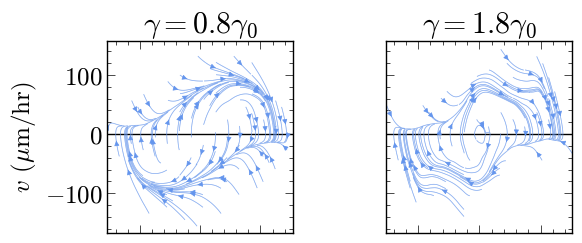

In [423]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 2.5 * nrows), sharey=True)

streamplot(
    axs[0],
    *process_gid(10),
    title=r"$\gamma=0.8\gamma_0$",
    n_skip=6,
    zero_line=True,
    **kwargs
)
streamplot(
    axs[1],
    *process_gid(110),
    title=r"$\gamma=1.8\gamma_0$",
    n_skip=6,
    zero_line=True,
    **kwargs
)
axs[1].set_ylabel("")
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[0].tick_params(labelbottom=False) 
axs[1].tick_params(labelbottom=False) 

# streamplot(
#     axs[0],
#     F1,
#     bounds1,
#     n_skip=6,
#     zero_line=True,
#     **kwargs
# )
# bistable_streamplot(
#     axs[1],
#     F2,
#     bounds2,
#     labels,
#     end_pts,
#     n_skip=6,
#     zero_line=True,
#     **kwargs
# )
# axs[1].set_ylabel("")

# plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
fig.savefig("paper_plots/varying_cell_tension_streams_A.pdf")